In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import rasterio
import statsmodels.api as sm

from scipy.special import inv_boxcox
from scipy import stats
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

<Axes: >

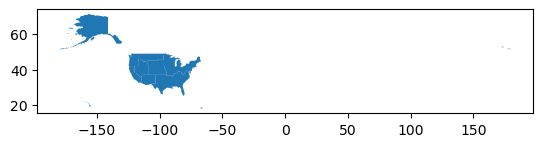

In [3]:
regionsUSFS_shp = gpd.read_file('Shapefiles/S_USA.AdministrativeRegion/S_USA.AdministrativeRegion.shp')
regionsUSFS_shp.plot()

<Axes: >

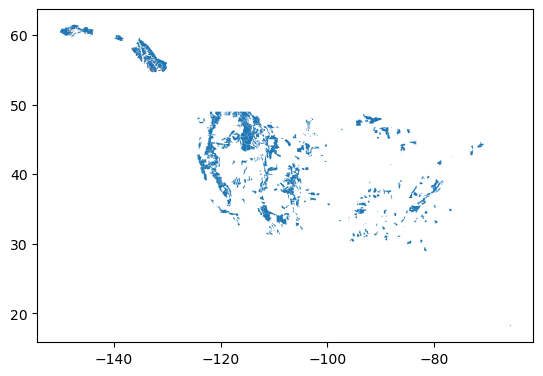

In [4]:
forestsUSFS_shp = gpd.read_file('Shapefiles/S_USA.AdministrativeRegion/S_USA.AdministrativeForest.shp')
forestsUSFS_shp.plot()

In [5]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.model_selection import train_test_split
from statsmodels.graphics.gofplots import ProbPlot
from pmdarima import auto_arima

In [6]:
# Read in data and remove any lingering commas
timberDf = pd.read_csv('/Users/louisgoodall/Desktop/Timber Data.csv')
cleanCols = ['Year','Quarter','Sold_Volume_MBF','Sold_Volume_CCF',
            'Sold_Value','Sold_per_MBF','Sold_per_CCF','Cut_Volume_MBF',
            'Cut_Volume_CCF','Cut_Value']
for col in cleanCols:
    timberDf[col] = timberDf[col].astype(str).str.replace(',', '', regex=False)
timberDf[cleanCols] = timberDf[cleanCols].astype(float)

# Long to wide, then recalculate the quarterly values. Original format has the quarterly
# values as cumulative
df  = timberDf.pivot(index=['National_Forest', 'Year', 'Species', 'Product'], columns='Quarter', values='Sold_Value').reset_index()
# df = df.drop(columns=np.nan)
df.rename(columns={1.0:'Q1', 2.0:'Q2', 3.0:'Q3', 4.0:'Q4'}, inplace=True)
df = df.replace(np.nan, 0)
df = df.assign(Q2 = df['Q2'] - df['Q1'],
               Q3 = df['Q3'] - df['Q2'],
               Q4 = df['Q4'] - df['Q3'])
df[['Q1','Q2','Q3','Q4']] = df[['Q1','Q2','Q3','Q4']].clip(lower=0)
df = df.assign(Total = df['Q2'] + df['Q3'] + df['Q4'] + df['Q1'])

# Back to long format and add columns that can be used for plotting/in a model
df = pd.melt(df, id_vars=['National_Forest', 'Year', 'Species'], value_vars=['Q1','Q2','Q3','Q4'], value_name='Sold_Value')
df['Year'] = df['Year'].astype(int)
df['Quarter'] = df['Quarter'].astype(str)
df['YearQuarter'] = df['Year'].astype(str) + df['Quarter']
df['Quarter'] = pd.PeriodIndex(df['YearQuarter'], freq='Q').to_timestamp()
df['Quarter_Num'] = df['YearQuarter'].str.split('Q').str[1].astype(int)
df['Numeric_Quarter'] = df['Year'] + (df['Quarter_Num'] - 1) / 4

# Total Harvest
#### This will serve as a template for the other models that I will deploy. More data is still needed to create fully functioning time series models

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
/var/folders/9b/6_fqcsbn0gj7ftczc3760qlr0000gn/T/ipykernel_18851/2039769564.py:20: SyntaxWarning: invalid escape sequence '\s'
  plot_lm_3.axes[0].set_ylabel('$\sqrt{Standardized Residuals}$')


Text(0, 0.5, '$\\sqrt{Standardized Residuals}$')

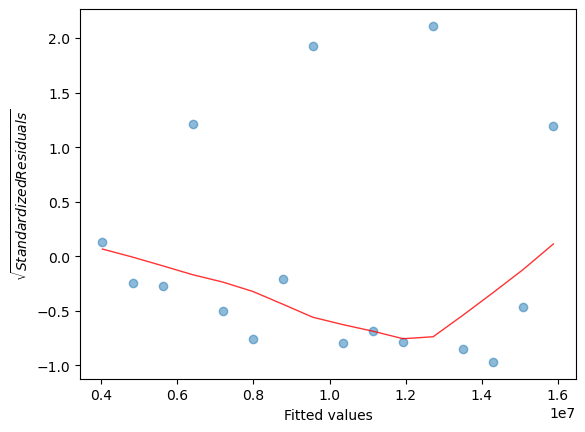

In [8]:
# Create total harvest dataframe and X/y objects then model
totalHarvestDf = df.groupby(['Numeric_Quarter'])[['Sold_Value']].agg('sum').reset_index()
X = totalHarvestDf['Numeric_Quarter']
y = totalHarvestDf['Sold_Value']
model = sm.OLS(y, sm.add_constant(X))
model_fit = model.fit()

# Plot standardised residuals vs. fitted values
plotDf = pd.concat([X, y], axis=1)
normalisedResiduals = model_fit.get_influence().resid_studentized_internal
fittedValues = model_fit.fittedvalues
plot_lm_3 = plt.figure()
plt.scatter(fittedValues, normalisedResiduals, alpha=0.5)
sns.regplot(x=fittedValues, y=normalisedResiduals,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{Standardized Residuals}$')

Text(0.5, 0, 'Quarter')

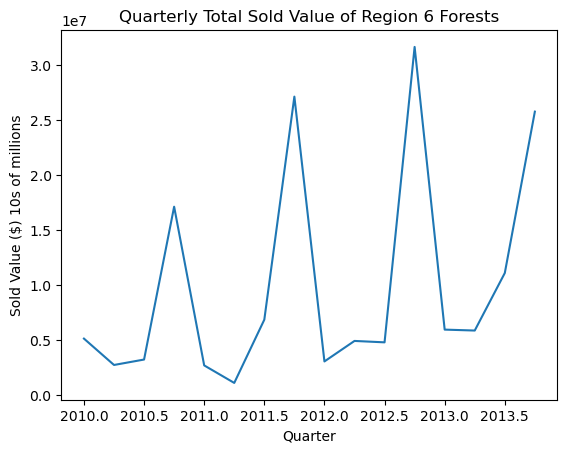

In [9]:
# Check out pattern of total sold value
sns.lineplot(totalHarvestDf, x='Numeric_Quarter', y='Sold_Value')
plt.title('Quarterly Total Sold Value of Region 6 Forests')
plt.ylabel("Sold Value ($) 10s of millions")
plt.xlabel('Quarter')

In [10]:
# Test the stationarity of the differenced y variable using the ADF test
# We did good
totalHarvestDf['valueDiff'] = totalHarvestDf['Sold_Value'].diff()
result = adfuller(totalHarvestDf['valueDiff'].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# Summary of SARIMAX output
# TEST FOR NOW, NEED TO CHECK REGULAR ARIMA TOO
train = totalHarvestDf[:int(0.8*(len(totalHarvestDf)))]
test = totalHarvestDf[int(0.8*(len(totalHarvestDf))):]
train = train[['Numeric_Quarter', 'Sold_Value']]
model = SARIMAX(train['Sold_Value'], order=(0,0,0), seasonal_order=(1,1,1,4))
result = model.fit()
result.summary()

ADF Statistic: -3.1679995394154705
p-value: 0.02191333462056013


/opt/anaconda3/envs/DS/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                Sold_Value   No. Observations:                   12
Model:             SARIMAX(1, 1, [1], 4)   Log Likelihood                -131.122
Date:                   Sat, 19 Apr 2025   AIC                            268.244
Time:                           21:27:08   BIC                            268.482
Sample:                                0   HQIC                           266.636
                                    - 12                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L4        0.6017      1.477      0.407      0.684      -2.293       3.497
ma.S.L4       -0.2334      1.833     -0.127      0.899      -3.826       3.359
sigma2      1.422e+13   1.07e-13   1.33e+26      0.000    1.42e+13    1.42e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 0.73
Prob(Q):                              0.76   Prob(JB):                         0.69
Heteroskedasticity (H):               0.95   Skew:                            -0.04
Prob(H) (two-sided):                  0.97   Kurtosis:                         1.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.69e+43. Standard errors may be unstable.
"""

In [11]:
model = ARIMA(train['Sold_Value'], order=(0,1,0))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Sold_Value   No. Observations:                   12
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -196.617
Date:                Sat, 19 Apr 2025   AIC                            395.233
Time:                        21:27:14   BIC                            395.631
Sample:                             0   HQIC                           394.982
                                 - 12                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.792e+14   7.78e+13      2.303      0.021    2.67e+13    3.32e+14
===================================================================================
Ljung-Box (L1) (Q):                   1.22   Jarque-Bera (JB):                 0.07
Prob(Q):                              0.27   Prob(JB):                         0.97
Heteroskedasticity (H):               3.20   Skew:                            -0.06
Prob(H) (two-sided):                  0.29   Kurtosis:                         2.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

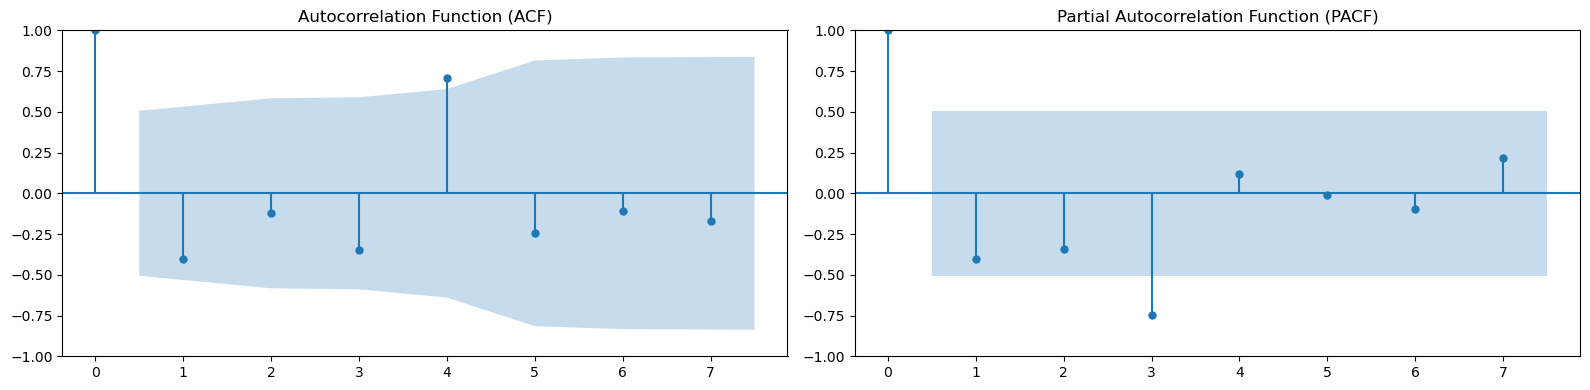

In [12]:
# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(totalHarvestDf['valueDiff'].dropna(), lags=7, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(totalHarvestDf['valueDiff'].dropna(), lags=7, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

In [13]:
train = df[:int(0.8*(len(df)))]
test = df[int(0.8*(len(df))):]
train = train[['Numeric_Quarter', 'Sold_Value']]
model = ARIMA(train['Sold_Value'], order=(5,1,6))
result = model.fit()
result.summary()
test

,National_Forest,Year,Species,Quarter,Sold_Value,YearQuarter,Quarter_Num,Numeric_Quarter
2854,Fremont-Winema,2011,Softwood Other,2011-10-01,0.00,2011Q4,4,2011.75
2855,Fremont-Winema,2011,White Fir,2011-10-01,126716.68,2011Q4,4,2011.75
2856,Fremont-Winema,2012,Douglas-fir,2012-10-01,49510.92,2012Q4,4,2012.75
2857,Fremont-Winema,2012,Fuelwood,2012-10-01,9347.50,2012Q4,4,2012.75
2858,Fremont-Winema,2012,Juniper,2012-10-01,20.00,2012Q4,4,2012.75
...,...,...,...,...,...,...,...,...
3563,Willamette,2013,Western Hemlock,2013-10-01,0.00,2013Q4,4,2013.75
3564,Willamette,2013,Western Red Cedar,2013-10-01,0.00,2013Q4,4,2013.75
3565,Willamette,2013,Western Red Cedar,2013-10-01,20.00,2013Q4,4,2013.75
3566,Willamette,2013,Western Red Cedar,2013-10-01,0.00,2013Q4,4,2013.75
